In [1]:
pip install GRAPE


Note: you may need to restart the kernel to use updated packages.


In [25]:
# ---------------------------------------------------------------------------
# 1. Library Imports and Setup
# ---------------------------------------------------------------------------
import ast
import math
import random
import re
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, roc_curve

try:
    import optuna
    _HAS_OPTUNA = True
except Exception:
    _HAS_OPTUNA = False

# Reproducibility
RNG = np.random.default_rng(42)
random.seed(42)
np.random.seed(42)
plt.rcParams["figure.figsize"] = (7, 5)

In [27]:
# ---------------------------------------------------------------------------
# 2. Data Loading and Preprocessing
# ---------------------------------------------------------------------------
file_path = "data.csv"
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure it exists.")
    raise SystemExit

candidate_targets = [
    "diagnosis", "Diagnosis", "target", "Target", "class", "Class",
    "label", "Label", "outcome", "Outcome"
]
target_col = next((c for c in candidate_targets if c in df.columns), None)
if target_col is None:
    target_col = df.columns[1]

y_raw = df[target_col].copy()

# Drop common ID-ish columns
_drop_id_cols = ["id", "ID", "Id", "patient_id", "Unnamed: 0"]
drop_id_cols = [c for c in _drop_id_cols if c in df.columns]
X_df = df.drop(columns=[target_col] + drop_id_cols, errors="ignore")

# Coerce numeric and drop all-NaN columns
for c in X_df.columns:
    X_df[c] = pd.to_numeric(X_df[c], errors="coerce")
X_df = X_df.dropna(axis=1, how="all")


def to_binary_malignant_positive(series: pd.Series) -> np.ndarray:
    s = series.copy()
    if s.dtype == object or str(s.dtype).startswith(("string", "category")):
        norm = s.astype(str).str.strip().str.lower()
        mapping = {"m": 1, "malignant": 1, "1": 1, "4": 1,
                   "b": 0, "benign": 0, "0": 0, "2": 0}
        mapped = norm.map(mapping)
        if mapped.isna().any():
            num = pd.to_numeric(norm, errors="coerce")
            uniques = set(pd.unique(num.dropna()))
            if uniques.issubset({0, 1}):
                return num.astype(int).values
            if uniques.issubset({2, 4}):
                return (num == 4).astype(int).values
            unknown = sorted(pd.unique(norm[mapped.isna()]))
            raise ValueError(f"Unrecognized target labels: {unknown}")
        return mapped.astype(int).values
    num = pd.to_numeric(s, errors="coerce")
    uniques = set(pd.unique(num.dropna()))
    if uniques.issubset({0, 1}):
        return num.astype(int).values
    if uniques.issubset({2, 4}):
        return (num == 4).astype(int).values
    raise ValueError(
        f"Cannot interpret target column '{series.name}' values: {sorted(uniques)}"
    )


y = to_binary_malignant_positive(y_raw)
X = X_df.values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print(
    f"Shapes / class balance: {X_train.shape}, {X_test.shape}, "
    f"{float(y_train.mean()):.4f}, {float(y_test.mean()):.4f}"
)



Shapes / class balance: (455, 30), (114, 30), 0.3736, 0.3684


In [28]:
# ---------------------------------------------------------------------------
# 3. Evaluation Functions
# ---------------------------------------------------------------------------

def sensitivity_at_specificity(y_true, y_score, target_spec=0.95):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    spec = 1.0 - fpr
    idx = np.where(spec >= target_spec)[0]
    best_i = np.argmax(spec) if len(idx) == 0 else idx[-1]
    return float(tpr[best_i]), float(spec[best_i]), float(thresholds[best_i])


def youden_j_threshold(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    J = tpr - fpr
    i = np.argmax(J)
    return float(tpr[i]), float(1.0 - fpr[i]), float(thresholds[i])


def eval_at_rule(y_true, y_score, rule="spec95"):
    if rule == "spec95":
        sens, spec, thr = sensitivity_at_specificity(y_true, y_score, target_spec=0.95)
    elif rule == "youden":
        sens, spec, thr = youden_j_threshold(y_true, y_score)
    else:
        raise ValueError("Unknown rule")
    return {"sensitivity": sens, "specificity": spec, "threshold": thr}


def summarize_fold_metrics(y_true, y_score, rule="spec95"):
    auroc = roc_auc_score(y_true, y_score)
    rule_stats = eval_at_rule(y_true, y_score, rule=rule)
    out = {"auroc": float(auroc)}
    out.update(rule_stats)
    return out

In [ ]:
# ---------------------------------------------------------------------------
# 4. BNF Grammar & GE Mapper
# ---------------------------------------------------------------------------

BNF = r"""
<cfg> ::= {"n_estimators": <n_estimators>,
           "learning_rate": <learning_rate>,
           "max_depth": <max_depth>,
           "subsample": <subsample>,
           "min_samples_split": <min_samples_split>,
           "calibration": <calibration>,
           "threshold_rule": <threshold_rule>}

<n_estimators> ::= 50 | 100 | 200 | 500
<learning_rate> ::= 0.001 | 0.01 | 0.1 | 0.2
<max_depth> ::= 3 | 5 | 7 | 9
<subsample> ::= 0.5 | 0.8 | 1.0
<min_samples_split> ::= 2 | 5 | 10
<calibration> ::= "none" | "sigmoid" | "isotonic"
<threshold_rule> ::= "youden" | "spec95"
"""

NONTERMS_TO_TRACK = [
    "n_estimators", "learning_rate", "max_depth",
    "subsample", "min_samples_split", "calibration", "threshold_rule"
]


class BNFGrammar:
    """Minimal BNF parser and GE mapper (codon-based)"""

    NT_RE = re.compile(r"<([^<>]+)>")

    def __init__(self, grammar_text: str):
        # Parse grammar into dict: nonterm -> list of production strings
        lines = [L for L in grammar_text.splitlines() if L.strip() and not L.strip().startswith("#")]
        joined = []
        # join multiline productions for readability
        buf = ""
        for L in lines:
            if '::=' in L and buf:
                joined.append(buf)
                buf = L
            else:
                buf += ("\n" if buf else "") + L
        if buf:
            joined.append(buf)

        g = {}
        for block in joined:
            if '::=' not in block:
                continue
            lhs, rhs = block.split('::=', 1)
            lhs = lhs.strip()
            assert lhs.startswith('<') and lhs.endswith('>'), f"Bad LHS: {lhs}"
            lhs_name = lhs[1:-1]
            # Split alternatives by '|'
            # Keep each production as raw string (can contain other <nonterminals>)
            prods = []
            for alt in rhs.split('|'):
                prod = alt.strip()
                # normalize whitespace inside productions
                # but preserve punctuation/quotes as-is
                # We'll expand nonterminals recursively by regex.
                prods.append(prod)
            g[lhs_name] = prods
        self.rules = g

    def count_combos(self):
        c = 1
        for nt, prods in self.rules.items():
            if nt == 'cfg':
                continue
            c *= max(1, len(prods))
        return c

    def expand(self, start_symbol: str, genome: list[int]):
        """
        Expand from start_symbol using the genome (codon list).
        Returns (expanded_string, choices_dict).
        choices_dict records which terminal was chosen for tracked nonterminals.
        """
        codon_idx = 0
        choices = {}

        def pick(nt: str) -> str:
            nonlocal codon_idx
            prods = self.rules[nt]
            if len(prods) == 0:
                raise ValueError(f"No productions for <{nt}>")
            # classic GE modulus mapping
            i = 0
            if len(prods) > 1:
                if len(genome) == 0:
                    # no genome? fall back to random
                    i = random.randrange(len(prods))
                else:
                    i = genome[codon_idx % len(genome)] % len(prods)
                codon_idx += 1
            else:
                # deterministic single production; still consume a codon to keep mapping consistent
                if len(genome) > 0:
                    _ = genome[codon_idx % len(genome)]
                    codon_idx += 1
                i = 0
            choice = prods[i]
            if nt in NONTERMS_TO_TRACK and '<' not in choice:
                # record literal token (strip quotes if present)
                literal = choice.strip()
                if literal.startswith('"') and literal.endswith('"'):
                    literal = literal[1:-1]
                try:
                    val = ast.literal_eval(literal)
                except Exception:
                    val = literal
                choices[nt] = val
            return choice

        def expand_string(s: str) -> str:
            # repeatedly substitute the leftmost <nonterminal>
            while True:
                m = self.NT_RE.search(s)
                if not m:
                    return s
                nt = m.group(1)
                sub = pick(nt)
                s = s[:m.start()] + sub + s[m.end():]

        start = start_symbol.strip()
        if start.startswith('<') and start.endswith('>'):
            start = start[1:-1]
        expanded = expand_string(f"<{start}>")
        return expanded, choices


# Instantiate grammar
GRAMMAR = BNFGrammar(BNF)
print("Stage-1 grammar combos (BNF):", GRAMMAR.count_combos())


Stage-1 grammar combos (BNF): 3456


In [31]:
# ---------------------------------------------------------------------------
# 5. Model Builder & Scoring
# ---------------------------------------------------------------------------

def make_estimator_from_config(cfg: dict):
    base_estimator = GradientBoostingClassifier(
        n_estimators=cfg["n_estimators"],
        learning_rate=cfg["learning_rate"],
        max_depth=cfg["max_depth"],
        subsample=cfg["subsample"],
        min_samples_split=cfg["min_samples_split"],
        random_state=42,
    )

    preprocess = [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]

    if cfg["calibration"] == "none":
        model = Pipeline(preprocess + [("clf", base_estimator)])
    else:
        model = Pipeline(
            preprocess
            + [
                (
                    "cal",
                    CalibratedClassifierCV(base_estimator, method=cfg["calibration"], cv=3),
                )
            ]
        )
    return model


def cv_score_config(cfg, X, y, n_splits=5, stage="stage1", sample_frac=0.8, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    aurocs, sens_list = [], []
    fold_idx = 0
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        if stage == "stage1" and sample_frac < 1.0:
            rng = np.random.default_rng(random_state + fold_idx)
            n = max(1, int(len(X_tr) * sample_frac))
            idx = rng.choice(len(X_tr), size=n, replace=False)
            X_tr, y_tr = X_tr[idx], y_tr[idx]
        fold_idx += 1

        model = make_estimator_from_config(cfg)
        model.fit(X_tr, y_tr)

        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_val)[:, 1]
        else:
            y_score = model.decision_function(X_val)
            y_score = 1 / (1 + np.exp(-y_score))

        m = summarize_fold_metrics(y_val, y_score, rule=cfg["threshold_rule"])
        aurocs.append(m["auroc"])
        sens_list.append(m["sensitivity"])
    return float(np.mean(aurocs)), float(np.mean(sens_list))


In [32]:
# ---------------------------------------------------------------------------
# 6. GE (GRAPE-style) Operators & Search
# ---------------------------------------------------------------------------

CODON_MAX = 2 ** 16 - 1


def random_genome(length=32):
    return [random.randint(0, CODON_MAX) for _ in range(length)]


def mutate(genome, rate=0.05):
    g = genome.copy()
    for i in range(len(g)):
        if random.random() < rate:
            g[i] = random.randint(0, CODON_MAX)
    return g


def crossover(g1, g2):
    if len(g1) != len(g2):
        raise ValueError("Genome lengths must match")
    if len(g1) < 2:
        return g1.copy(), g2.copy()
    p = random.randint(1, len(g1) - 1)
    return g1[:p] + g2[p:], g2[:p] + g1[p:]


def genome_to_config_with_choices(genome, grammar: BNFGrammar):
    phenotype_str, choices = grammar.expand('<cfg>', genome)
    try:
        cfg = ast.literal_eval(phenotype_str)
    except Exception as e:
        raise ValueError(f"Failed to eval phenotype: {phenotype_str}\nError: {e}")
    # ensure numeric typing for certain keys
    for k in ["n_estimators", "max_depth", "min_samples_split"]:
        cfg[k] = int(cfg[k])
    for k in ["learning_rate", "subsample"]:
        cfg[k] = float(cfg[k])
    return cfg, choices


def run_grape(
    grammar: BNFGrammar,
    X,
    y,
    n_trials=30,
    pop_size=10,
    genome_length=32,
    cx_prob=0.9,
    mut_rate=0.05,
    stage="stage1",
    sample_frac=0.8,
    random_state=42,
):
    rng = random.Random(random_state)
    pop = [random_genome(genome_length) for _ in range(pop_size)]

    option_perf = {k: defaultdict(list) for k in NONTERMS_TO_TRACK}
    records = []

    def evaluate(g):
        cfg, choices = genome_to_config_with_choices(g, grammar)
        au, se = cv_score_config(
            cfg, X, y, n_splits=5, stage=stage, sample_frac=sample_frac, random_state=random_state
        )
        records.append((cfg, au, se))
        # attribute performance to discrete choices
        for k, v in choices.items():
            option_perf[k][v].append(au)
        return au + 1e-3 * se

    fitness = [evaluate(g) for g in pop]

    def tournament():
        i, j = rng.randrange(len(pop)), rng.randrange(len(pop))
        return i if fitness[i] >= fitness[j] else j

    eval_count = len(pop)
    best_idx = int(np.argmax(fitness))

    while eval_count < n_trials:
        p1, p2 = tournament(), tournament()
        c1, c2 = pop[p1].copy(), pop[p2].copy()
        if rng.random() < cx_prob:
            c1, c2 = crossover(c1, c2)
        c1 = mutate(c1, mut_rate)
        c2 = mutate(c2, mut_rate)

        f1 = evaluate(c1)
        eval_count += 1
        pop.append(c1)
        fitness.append(f1)
        worst = int(np.argmin(fitness))
        pop.pop(worst)
        fitness.pop(worst)

        if eval_count >= n_trials:
            break

        f2 = evaluate(c2)
        eval_count += 1
        pop.append(c2)
        fitness.append(f2)
        worst = int(np.argmin(fitness))
        pop.pop(worst)
        fitness.pop(worst)

        best_idx = int(np.argmax(fitness))

    best_genome = pop[best_idx]
    best_cfg, _ = genome_to_config_with_choices(best_genome, grammar)

    option_means = {k: {opt: float(np.mean(vals)) for opt, vals in d.items()} for k, d in option_perf.items()}

    return {
        "best_config": best_cfg,
        "best_fitness": float(fitness[best_idx]),
        "records": records,
        "option_means": option_means,
        "grammar": grammar,
    }


In [33]:
# ---------------------------------------------------------------------------
# 7. Grammar Pruning (Stage-2)
# ---------------------------------------------------------------------------

def build_pruned_bnf(original_bnf_text: str, option_means: dict, quantile=0.25, min_keep=1) -> str:
    """
    Build a new BNF text with productions pruned based on option_means.
    Only prunes the tracked nonterminals in NONTERMS_TO_TRACK.
    """
    # Parse into temporary structure: nt -> productions (as strings)
    tmp = BNFGrammar(original_bnf_text).rules

    def prune_list(nt: str, prods: list[str]):
        if nt not in NONTERMS_TO_TRACK:
            return prods
        means = option_means.get(nt, {})
        # Convert literal strings to typed values to match keys in option_means
        typed = []
        for p in prods:
            lit = p.strip()
            if lit.startswith('"') and lit.endswith('"'):
                val = lit[1:-1]
            else:
                try:
                    val = ast.literal_eval(lit)
                except Exception:
                    val = lit
            typed.append((p, val))
        vals = [means.get(val, 0.0) for _, val in typed]
        if len(vals) == 0:
            return prods
        thresh = np.quantile(vals, quantile)
        kept_pairs = [(p, val) for (p, val), v in zip(typed, vals) if v >= thresh]
        if len(kept_pairs) < min_keep:
            # keep top min_keep
            order = sorted(zip(typed, vals), key=lambda t: t[1], reverse=True)
            kept_pairs = [pair for (pair, _v) in order[:min_keep]]
        return [p for p, _ in kept_pairs]

    pruned_rules = {}
    for nt, prods in tmp.items():
        pruned_rules[nt] = prune_list(nt, prods)

    # Reconstruct BNF text
    lines = []
    for nt, prods in pruned_rules.items():
        alts = " | ".join(prods)
        lines.append(f"<{nt}> ::= {alts}")
    return "\n".join(lines)




--- Stage 1: Global Exploration (GE over BNF) ---
Stage-1 best (proxy fitness): 0.9918256965944274
Stage-1 best config: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 5, 'subsample': 0.8, 'min_samples_split': 10, 'calibration': 'isotonic', 'threshold_rule': 'youden'}

--- Stage 2: Pruned Exploitation ---
Stage-2 grammar combos (BNF): 216
Stage-2 best (proxy fitness): 0.9918714138286894
Stage-2 best config: {'n_estimators': 500, 'learning_rate': 0.01, 'max_depth': 5, 'subsample': 0.5, 'min_samples_split': 10, 'calibration': 'sigmoid', 'threshold_rule': 'spec95'}

--- Baselines (same total budget) ---


[I 2025-08-17 23:03:50,059] A new study created in memory with name: no-name-d9fb8947-15d8-453c-957d-9f29f4082363
[I 2025-08-17 23:03:52,792] Trial 0 finished with value: -0.9875370485036119 and parameters: {'n_estimators': 100, 'learning_rate': 0.001, 'max_depth': 9, 'subsample': 0.5, 'min_samples_split': 2, 'calibration': 'none', 'threshold_rule': 'youden'}. Best is trial 0 with value: -0.9875370485036119.
[I 2025-08-17 23:03:55,348] Trial 1 finished with value: -0.9872835913312694 and parameters: {'n_estimators': 100, 'learning_rate': 0.001, 'max_depth': 3, 'subsample': 0.5, 'min_samples_split': 2, 'calibration': 'sigmoid', 'threshold_rule': 'spec95'}. Best is trial 0 with value: -0.9875370485036119.
[I 2025-08-17 23:04:00,065] Trial 2 finished with value: -0.9696541795665633 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 9, 'subsample': 1.0, 'min_samples_split': 2, 'calibration': 'isotonic', 'threshold_rule': 'youden'}. Best is trial 0 with value: -0.98753


=== Baseline Comparison Summary ===
         method  cv_auroc  cv_sensitivity  test_auroc  test_sensitivity  \
0     GE_2Stage  0.991538        0.970588    0.998016          0.976190   
2     SmallGrid  0.989474        0.964706    0.997685          0.976190   
3  RandomSearch  0.987410        0.958824    0.997024          0.976190   
4     OptunaTPE  0.978173        0.935294    0.996362          0.952381   
1    DefaultGBM  0.985862        0.929412    0.996032          0.952381   

       time_s  
0  153.363111  
2  181.206697  
3  128.331332  
4   79.437020  
1    1.701098  


<Figure size 700x500 with 0 Axes>

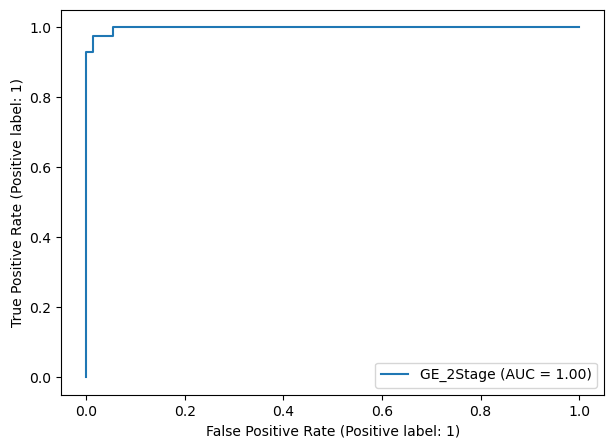

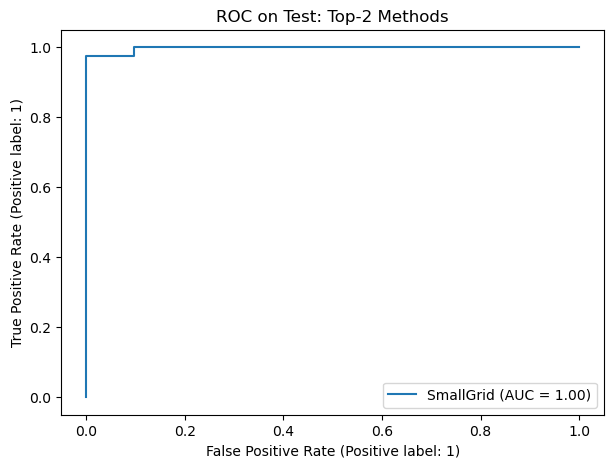

In [ ]:
# ---------------------------------------------------------------------------
# 8. Baselines & Fair Comparison Utilities
# ---------------------------------------------------------------------------
import time
from dataclasses import dataclass


# --- Helper baselines that were referenced by wrappers ---

def run_random_search(grammar: BNFGrammar, X, y, n_trials=30, stage="stage1", sample_frac=0.8, random_state=42):
    """Simple random search over the BNF by sampling random genomes."""
    recs = []
    for t in range(n_trials):
        g = random_genome(32)
        cfg, _ = genome_to_config_with_choices(g, grammar)
        au, se = cv_score_config(
            cfg, X, y, n_splits=5, stage=stage, sample_frac=sample_frac, random_state=random_state + t
        )
        recs.append((cfg, au, se))
    best = max(recs, key=lambda r: (r[1], r[2]))
    return {"best_config": best[0], "records": recs}


def run_optuna_tpe(grammar: BNFGrammar, X, y, n_trials=30, stage="stage1", sample_frac=0.8, random_state=42):
    """Optuna TPE baseline over categorical spaces extracted from the BNF."""
    if not _HAS_OPTUNA:
        print("Optuna not installed. Skipping TPE baseline.")
        return None

    # Build categorical search spaces from grammar
    cat_spaces = {}
    for nt in NONTERMS_TO_TRACK:
        prods = grammar.rules[nt]
        choices = []
        for p in prods:
            lit = p.strip()
            if lit.startswith('"') and lit.endswith('"'):
                val = lit[1:-1]
            else:
                try:
                    val = ast.literal_eval(lit)
                except Exception:
                    val = lit
            choices.append(val)
        cat_spaces[nt] = choices

    def objective(trial):
        cfg = {k: trial.suggest_categorical(k, v) for k, v in cat_spaces.items()}
        au, se = cv_score_config(
            cfg, X, y, n_splits=5, stage=stage, sample_frac=sample_frac, random_state=random_state
        )
        return -(au + 1e-3 * se)

    sampler = optuna.samplers.TPESampler(seed=random_state)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    best_cfg = study.best_trial.params
    best_val = -study.best_value
    return {"best_config": best_cfg, "best_value": best_val, "study": study}


@dataclass
class RunResult:
    name: str
    best_config: dict
    proxy_fitness: float
    cv_auroc: float
    cv_sensitivity: float
    wall_time_s: float
    records: list


def evaluate_on_test(cfg: dict, X_train, y_train, X_test, y_test):
    model = make_estimator_from_config(cfg)
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)
        y_score = 1 / (1 + np.exp(-y_score))
    return summarize_fold_metrics(y_test, y_score, rule=cfg["threshold_rule"])


def run_default_baseline(X, y, stage="stage1", sample_frac=0.8):
    """Train a sensible default GBM (sklearn defaults + our pipeline)."""
    cfg = {
        "n_estimators": 100,
        "learning_rate": 0.1,
        "max_depth": 3,
        "subsample": 1.0,
        "min_samples_split": 2,
        "calibration": "none",
        "threshold_rule": "spec95",
    }
    t0 = time.perf_counter()
    au, se = cv_score_config(cfg, X, y, n_splits=5, stage=stage, sample_frac=sample_frac)
    wall = time.perf_counter() - t0
    return RunResult(
        name="DefaultGBM", best_config=cfg, proxy_fitness=au + 1e-3 * se,
        cv_auroc=au, cv_sensitivity=se, wall_time_s=wall, records=[(cfg, au, se)]
    )


def run_grid_search_small(grammar: BNFGrammar, X, y, stage="stage1", sample_frac=0.8):
    """A tiny grid (coarse) to keep cost low; acts as a strong classic baseline."""
    # choose a subset for speed
    subset = {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5],
        "subsample": [0.8, 1.0],
        "min_samples_split": [2, 5],
        "calibration": ["none"],
        "threshold_rule": ["youden", "spec95"],
    }
    keys = list(subset.keys())
    from itertools import product
    recs = []
    t0 = time.perf_counter()
    for vals in product(*[subset[k] for k in keys]):
        cfg = {k: v for k, v in zip(keys, vals)}
        au, se = cv_score_config(cfg, X, y, n_splits=5, stage=stage, sample_frac=sample_frac)
        recs.append((cfg, au, se))
    wall = time.perf_counter() - t0
    best = max(recs, key=lambda r: (r[1], r[2]))
    return RunResult(
        name="SmallGrid", best_config=best[0], proxy_fitness=best[1] + 1e-3 * best[2],
        cv_auroc=best[1], cv_sensitivity=best[2], wall_time_s=wall, records=recs
    )


def run_random_search_baseline(grammar: BNFGrammar, X, y, n_trials=30, stage="stage1", sample_frac=0.8, random_state=42):
    t0 = time.perf_counter()
    out = run_random_search(grammar, X, y, n_trials, stage, sample_frac, random_state)
    wall = time.perf_counter() - t0
    best_cfg = out["best_config"]
    au, se = cv_score_config(best_cfg, X, y, n_splits=5, stage=stage, sample_frac=sample_frac)
    return RunResult("RandomSearch", best_cfg, au + 1e-3 * se, au, se, wall, out["records"])


def run_optuna_tpe_baseline(grammar: BNFGrammar, X, y, n_trials=30, stage="stage1", sample_frac=0.8, random_state=42):
    if not _HAS_OPTUNA:
        return None
    t0 = time.perf_counter()
    out = run_optuna_tpe(grammar, X, y, n_trials, stage, sample_frac, random_state)
    wall = time.perf_counter() - t0
    best_cfg = out["best_config"]
    au, se = cv_score_config(best_cfg, X, y, n_splits=5, stage=stage, sample_frac=sample_frac)
    return RunResult("OptunaTPE", best_cfg, au + 1e-3 * se, au, se, wall, [])


if __name__ == "__main__":
    STAGE1_TRIALS = 12
    STAGE2_TRIALS = 8
    POP = 8
    GENOME_LEN = 24  # number of codons per genome
    SAMPLE_FRAC_STAGE1 = 0.8
    total_budget = STAGE1_TRIALS + STAGE2_TRIALS
    # ---------------- Stage 1: GE over BNF ----------------
    print("\n--- Stage 1: Global Exploration (GE over BNF) ---")
    t0 = time.perf_counter()
    ge1 = run_grape(
        GRAMMAR, X_train, y_train,
        n_trials=STAGE1_TRIALS, pop_size=POP, genome_length=GENOME_LEN,
        cx_prob=0.9, mut_rate=0.05, stage="stage1", sample_frac=SAMPLE_FRAC_STAGE1, random_state=42,
    )
    stage1_wall = time.perf_counter() - t0
    print("Stage-1 best (proxy fitness):", ge1["best_fitness"])
    print("Stage-1 best config:", ge1["best_config"])
    # ---------------- Stage 2: Pruned Exploitation ----------------
    print("\n--- Stage 2: Pruned Exploitation ---")
    pruned_bnf_text = build_pruned_bnf(BNF, ge1["option_means"], quantile=0.25, min_keep=1)
    GRAMMAR_STAGE2 = BNFGrammar(pruned_bnf_text)
    print("Stage-2 grammar combos (BNF):", GRAMMAR_STAGE2.count_combos())

    t1 = time.perf_counter()
    ge2 = run_grape(
        GRAMMAR_STAGE2, X_train, y_train,
        n_trials=STAGE2_TRIALS, pop_size=POP, genome_length=GENOME_LEN,
        cx_prob=0.9, mut_rate=0.05, stage="stage2", sample_frac=1.0, random_state=43,
    )
    stage2_wall = time.perf_counter() - t1
    print("Stage-2 best (proxy fitness):", ge2["best_fitness"])
    print("Stage-2 best config:", ge2["best_config"])

    # GE summary result
    ge_best_cfg = ge2["best_config"]
    ge_cv_au, ge_cv_se = cv_score_config(ge_best_cfg, X_train, y_train, n_splits=5, stage="stage2", sample_frac=1.0)
    ge_total_wall = stage1_wall + stage2_wall
    ge_run = RunResult("GE_2Stage", ge_best_cfg, ge2["best_fitness"], ge_cv_au, ge_cv_se, ge_total_wall, ge2["records"])

    # ---------------- Baselines (same total budget) ----------------
    print("\n--- Baselines (same total budget) ---")
    default_run = run_default_baseline(X_train, y_train, stage="stage1", sample_frac=SAMPLE_FRAC_STAGE1)
    grid_run    = run_grid_search_small(GRAMMAR, X_train, y_train, stage="stage1", sample_frac=SAMPLE_FRAC_STAGE1)
    rnd_run     = run_random_search_baseline(GRAMMAR, X_train, y_train, n_trials=total_budget, stage="stage1", sample_frac=SAMPLE_FRAC_STAGE1, random_state=7)
    tpe_run     = run_optuna_tpe_baseline(GRAMMAR, X_train, y_train, n_trials=total_budget, stage="stage1", sample_frac=SAMPLE_FRAC_STAGE1, random_state=7) if _HAS_OPTUNA else None

    runs = [ge_run, default_run, grid_run, rnd_run] + ([tpe_run] if tpe_run is not None else [])

    # ---------------- Test-set evaluation for each best config ----------------
    rows = []
    for r in runs:
        test_m = evaluate_on_test(r.best_config, X_train, y_train, X_test, y_test)
        rows.append({
            "method": r.name,
            "cv_auroc": r.cv_auroc,
            "cv_sensitivity": r.cv_sensitivity,
            "proxy_fitness": r.proxy_fitness,
            "time_s": r.wall_time_s,
            "test_auroc": test_m["auroc"],
            "test_sensitivity": test_m["sensitivity"],
            "test_specificity": test_m["specificity"],
            "test_threshold": test_m["threshold"],
            "best_config": r.best_config,
        })

    summary_df = pd.DataFrame(rows).sort_values(by=["test_auroc", "test_sensitivity"], ascending=False)
    pd.set_option('display.max_colwidth', None)
    print("\n=== Baseline Comparison Summary ===")
    print(summary_df[["method", "cv_auroc", "cv_sensitivity", "test_auroc", "test_sensitivity", "time_s"]])

    # Save artifacts
    summary_df.to_csv("baseline_comparison_summary.csv", index=False)
    with open("best_configs.json", "w", encoding="utf-8") as f:
        import json
        json.dump({row["method"]: row["best_config"] for row in rows}, f, indent=2)

    # ---------------- Final ROC for top-2 methods ----------------
    from sklearn.metrics import RocCurveDisplay
    top2 = summary_df.head(2)
    plt.figure()
    for _, row in top2.iterrows():
        cfg = row["best_config"]
        model = make_estimator_from_config(cfg)
        model.fit(X_train, y_train)
        if hasattr(model, "predict_proba"):
            scores = model.predict_proba(X_test)[:, 1]
        else:
            scores = model.decision_function(X_test)
            scores = 1 / (1 + np.exp(-scores))
        RocCurveDisplay.from_predictions(y_test, scores, name=row["method"])
    plt.title("ROC on Test: Top-2 Methods")
    plt.show()
